In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import cross_val_score, StratifiedKFold

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, precision_recall_curve, fbeta_score, precision_score,recall_score, PrecisionRecallDisplay, f1_score, accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer


from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier





In [134]:

data = pd.read_csv("credit_risk_dataset.csv")

### Разведочный анализ данных

In [135]:
data.describe()



,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


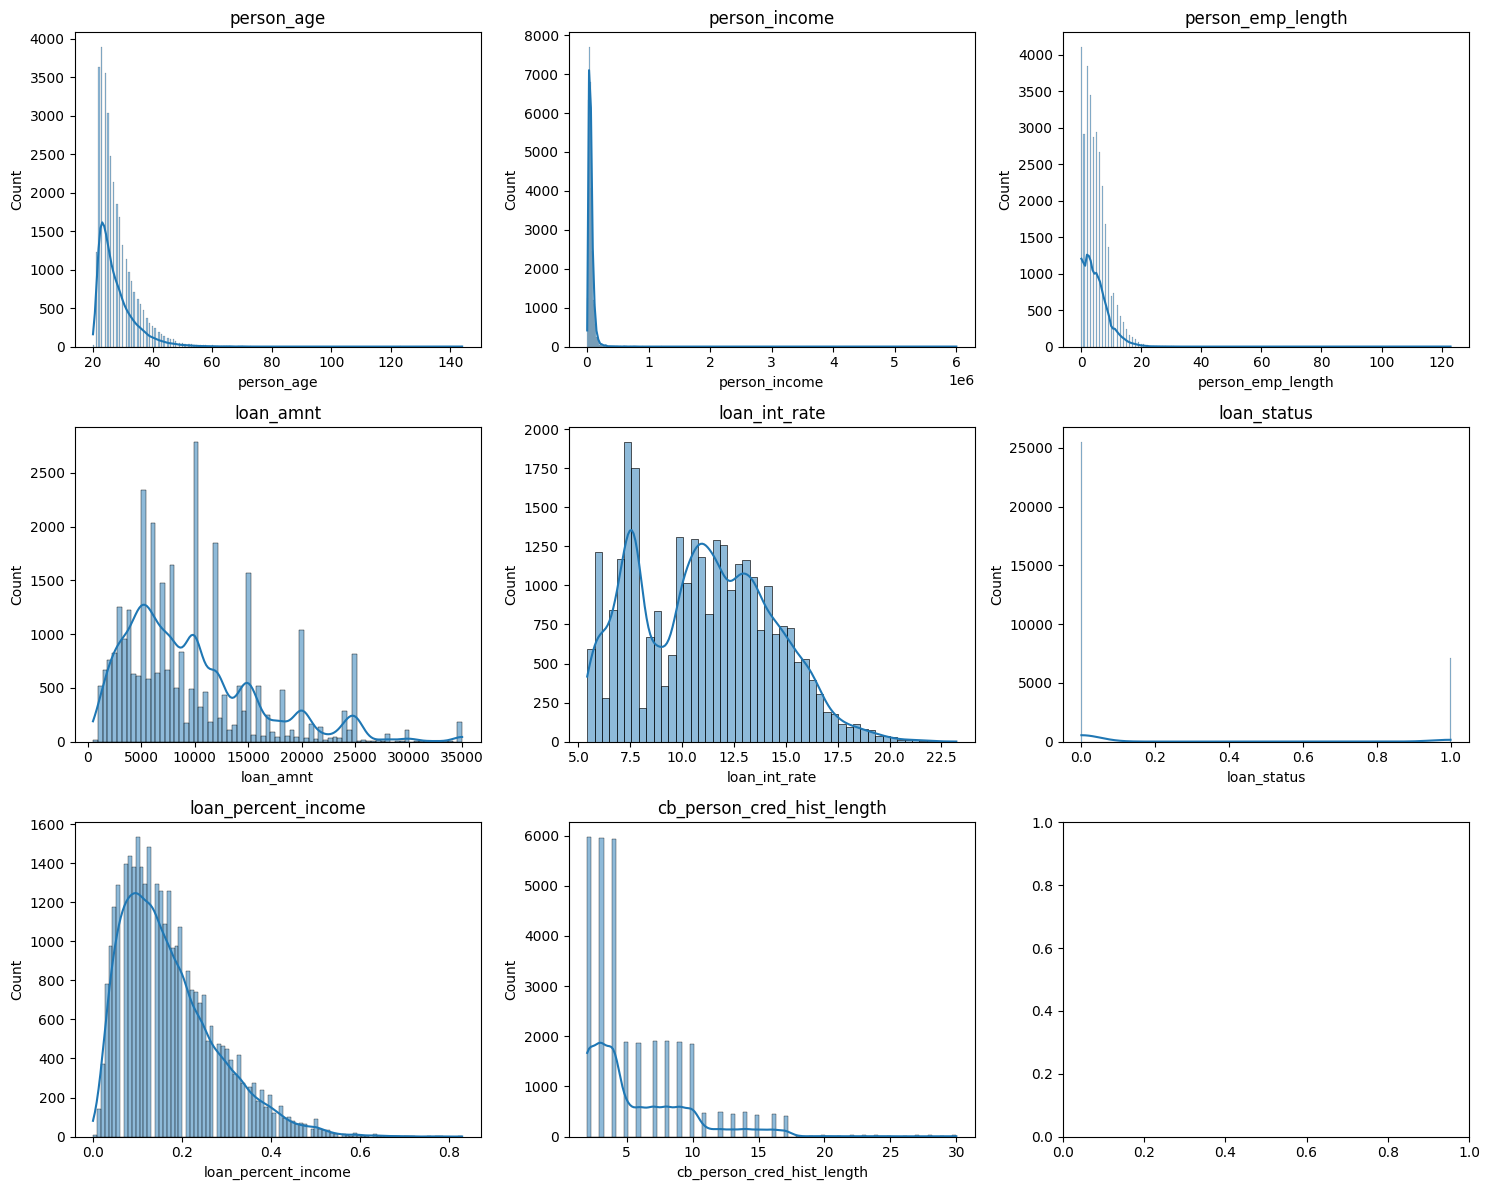

In [136]:
num_cols = data.select_dtypes(include=[np.number]).columns
n = len(num_cols)
n_cols = 3  # графиков в ряд
n_rows = (n + n_cols - 1) // n_cols  # округляем вверх

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))

for i, col in enumerate(num_cols):
    ax = axes.flat[i]  
    sns.histplot(data[col], kde=True, ax=ax)
    ax.set_title(col)


plt.tight_layout()
plt.show()

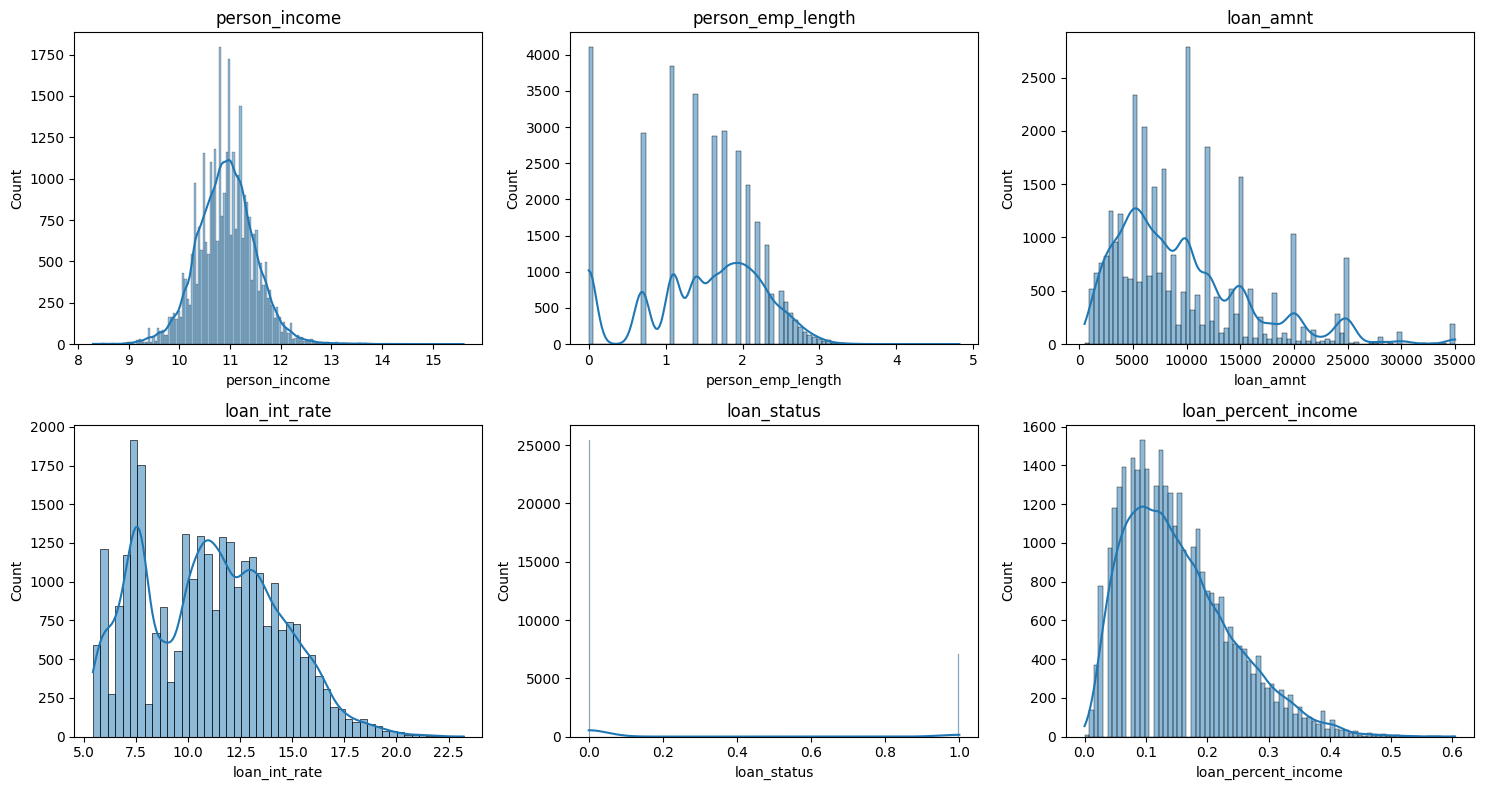

In [137]:
# bins = [0, 25, 35, 50, 65, 100]
# labels = ['student', 'young_adult', 'middle_age', 'pre_retirement', 'senior']
# data['age_group'] = pd.cut(data['person_age'], bins=bins, labels=labels).astype(str) сделал оценку через permutatoin importances и увмдел что ен имеет смысла
data['person_emp_length'] = np.log1p(data['person_emp_length'])
data['person_income'] = np.log1p(data['person_income'])
data['loan_percent_income'] = np.log1p(data['loan_percent_income'])
data = data.drop(columns=['cb_person_cred_hist_length', 'cb_person_default_on_file', 'person_age'], axis = 1)
num_cols = data.select_dtypes(include=[np.number]).columns
n = len(num_cols)
n_cols = 3  # графиков в ряд
n_rows = (n + n_cols - 1) // n_cols  # округляем вверх

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))

for i, col in enumerate(num_cols):
    ax = axes.flat[i]  
    sns.histplot(data[col], kde=True, ax=ax)
    ax.set_title(col)

plt.tight_layout()
plt.show()

<Axes: xlabel='loan_status', ylabel='person_income'>

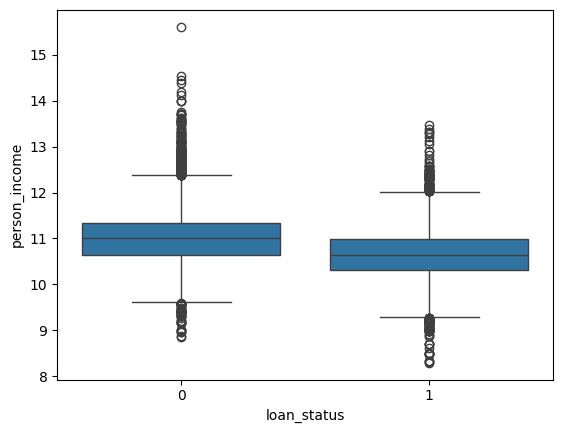

In [138]:
sns.boxplot(x='loan_status', y='person_income', data=data)


In [139]:
data['loan_status'].value_counts()


loan_status
0    25473
1     7108
Name: count, dtype: int64

In [140]:
corr = data.select_dtypes(include= [np.number]).corr()
corr



,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income
person_income,1.000000,0.207550,0.426318,-0.021271,-0.282808,-0.380661
person_emp_length,0.207550,1.000000,0.110667,-0.057852,-0.096808,-0.050376
loan_amnt,0.426318,0.110667,1.000000,0.146813,0.105376,0.580761
loan_int_rate,-0.021271,-0.057852,0.146813,1.000000,0.335133,0.122380
loan_status,-0.282808,-0.096808,0.105376,0.335133,1.000000,0.371942
loan_percent_income,-0.380661,-0.050376,0.580761,0.122380,0.371942,1.000000


<Axes: >

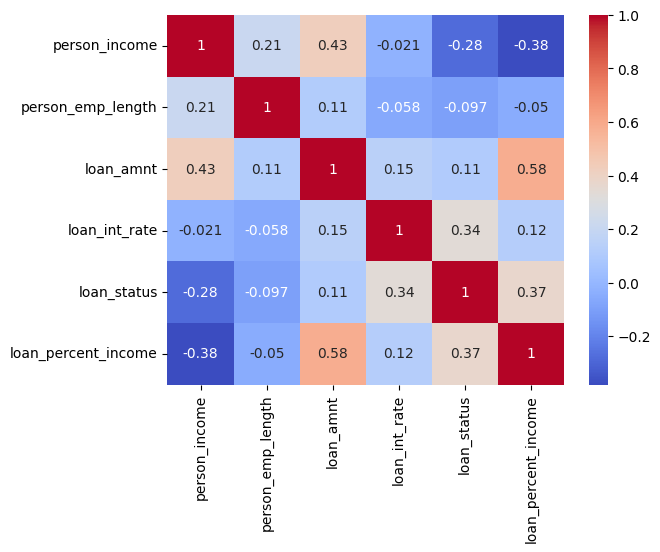

In [141]:
sns.heatmap(corr,annot=True, cmap="coolwarm")


### Обработка данных и подбор гиперпараметров с помощью OPTUNA


In [142]:
X = data.drop(columns=['loan_status'])
y = data['loan_status']
num_cols = X.select_dtypes(include=[np.number]).columns.to_list()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.to_list()
num_idx = [X.columns.get_loc(c) for c in num_cols]
cat_idx = [X.columns.get_loc(c) for c in cat_cols]




X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)




In [ ]:
from collections import Counter
import optuna
from sklearn.metrics import average_precision_score


counter = Counter(y)
scale_pos_weight = counter[0] / counter[1]

def objective(trial):

    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'depth': trial.suggest_int('depth', 3, 8),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 200),
        'iterations': trial.suggest_int('iterations', 400, 2000),
        'random_seed': 42,
        'loss_function': 'Logloss',
        'eval_metric': 'PRAUC',  # метрика для логов, итог считаем вручную как average_precision
        'scale_pos_weight': scale_pos_weight
    }
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    model = CatBoostClassifier(**params, cat_features=cat_cols, verbose=0)

    model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=100, use_best_model=True)

    y_proba = model.predict_proba(X_test)[:, 1]
    prauc = average_precision_score(y_test, y_proba)
    
    return np.mean(prauc)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("Best PR AUC: ", study.best_value)







[I 2025-10-20 21:14:14,729] A new study created in memory with name: no-name-bb9e52c3-4acf-4c13-94ca-df3ddcd6040d


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-10-20 21:15:11,458] Trial 0 finished with value: 0.8687714667853529 and parameters: {'learning_rate': 0.01267298550264179, 'depth': 3, 'l2_leaf_reg': 9.626816766752809, 'subsample': 0.8817917816524226, 'colsample_bylevel': 0.8995086933025341, 'min_data_in_leaf': 165, 'iterations': 723}. Best is trial 0 with value: 0.8687714667853529.
[I 2025-10-20 21:16:07,849] Trial 1 finished with value: 0.8895518184987826 and parameters: {'learning_rate': 0.02514955722805817, 'depth': 8, 'l2_leaf_reg': 7.187491335448351, 'subsample': 0.514332321846274, 'colsample_bylevel': 0.5914127805510753, 'min_data_in_leaf': 123, 'iterations': 542}. Best is trial 1 with value: 0.8895518184987826.
[I 2025-10-20 21:17:05,231] Trial 2 finished with value: 0.9004608561020815 and parameters: {'learning_rate': 0.045959828162755303, 'depth': 7, 'l2_leaf_reg': 5.625332009244173, 'subsample': 0.5827318437738958, 'colsample_bylevel': 0.6399748175054452, 'min_data_in_leaf': 28, 'iterations': 556}. Best is trial 2 w

In [154]:
best_params = study.best_params
final_model = CatBoostClassifier(
    **best_params,
    random_seed=42,
    loss_function='Logloss',
    eval_metric='PRAUC',
    scale_pos_weight=scale_pos_weight,
    verbose=False,
    cat_features=cat_cols  # или cat_idx, если используете индексы
)

# Обучение на всём train с early stopping
final_model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    early_stopping_rounds=100,
    use_best_model=True,
    verbose=100
)

0:	learn: 0.8864745	test: 0.8816902	best: 0.8816902 (0)	total: 94.9ms	remaining: 2m 22s
100:	learn: 0.9471131	test: 0.9450811	best: 0.9450811 (100)	total: 8.33s	remaining: 1m 55s
200:	learn: 0.9558646	test: 0.9517785	best: 0.9518286 (198)	total: 16.5s	remaining: 1m 46s
300:	learn: 0.9617198	test: 0.9555040	best: 0.9555040 (300)	total: 24.5s	remaining: 1m 37s
400:	learn: 0.9647842	test: 0.9576129	best: 0.9576169 (399)	total: 32.5s	remaining: 1m 29s
500:	learn: 0.9676225	test: 0.9590849	best: 0.9591163 (496)	total: 40.5s	remaining: 1m 20s
600:	learn: 0.9700994	test: 0.9600571	best: 0.9600571 (600)	total: 48.2s	remaining: 1m 12s
700:	learn: 0.9717287	test: 0.9607250	best: 0.9607310 (699)	total: 56s	remaining: 1m 3s
800:	learn: 0.9732579	test: 0.9610288	best: 0.9610921 (777)	total: 1m 3s	remaining: 55.5s
900:	learn: 0.9746008	test: 0.9611966	best: 0.9612145 (899)	total: 1m 11s	remaining: 47.3s
1000:	learn: 0.9760129	test: 0.9613824	best: 0.9615355 (970)	total: 1m 18s	remaining: 39.3s
1100:

### Выбор подходящих метрик

In [155]:

from sklearn.metrics import auc
predict = final_model.predict(X_test)

print(f1_score(y_test, predict))
print(recall_score(y_test, predict))
print(precision_score(y_test, predict))


0.8189806678383128
0.819268635724332
0.8186929023190442


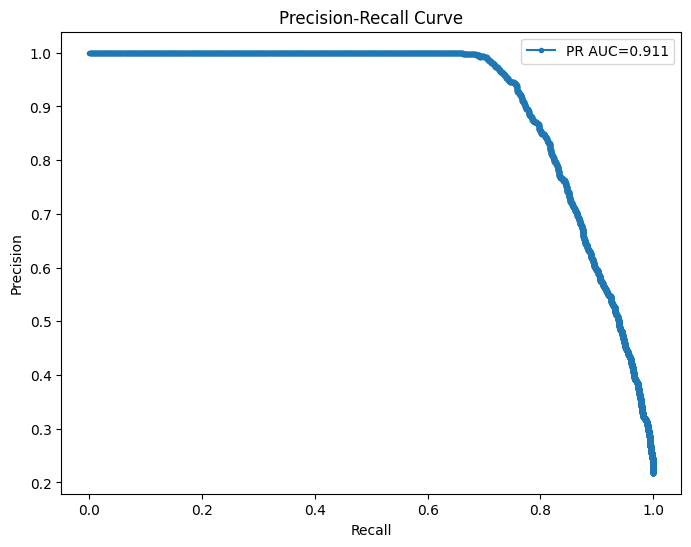

In [156]:
y_proba = final_model.predict_proba(X_test)[:, 1]
precision, recall, treshold = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)
plt.figure(figsize=(8,6))
plt.plot(recall, precision, marker='.', label=f'PR AUC={pr_auc:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [157]:
from sklearn.model_selection import cross_val_score, StratifiedKFold


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_score = cross_val_score(final_model, X_train, y_train, cv=cv, scoring='average_precision', n_jobs=-1).mean()

print(cross_score)


0.903060768840969


In [ ]:
from sklearn.inspection import permutation_importance

r = permutation_importance(final_model, X_test, y_test, n_repeats=15, random_state=42, scoring='average_precision')
print(r.importances_mean)

feat_imps = pd.DataFrame({
    'feature' : X_test.columns,
    'importance' : r.importances_mean
}).sort_values(by='importance', ascending=False)

feat_imps




c:\Users\Даниэль\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Даниэль\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Даниэль\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Даниэль\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Даниэль\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.

[0.1507005  0.19454374 0.02393466 0.08165974 0.11736151 0.0097642
 0.037077   0.27461386]


,feature,importance
7,loan_percent_income,0.274614
1,person_home_ownership,0.194544
0,person_income,0.150700
4,loan_grade,0.117362
3,loan_intent,0.081660
6,loan_int_rate,0.037077
2,person_emp_length,0.023935
5,loan_amnt,0.009764


<Axes: xlabel='importance', ylabel='feature'>

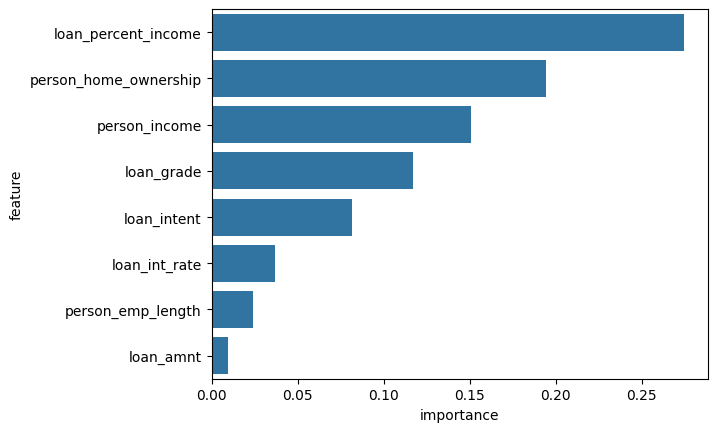

In [148]:
sns.barplot(data=feat_imps, x='importance', y='feature', orient='h')

In [149]:
data

,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income
0,10.985310,RENT,4.820282,PERSONAL,D,35000,16.02,1,0.463734
1,9.169623,OWN,1.791759,EDUCATION,B,1000,11.14,0,0.095310
2,9.169623,MORTGAGE,0.693147,MEDICAL,C,5500,12.87,1,0.451076
3,11.089821,RENT,1.609438,MEDICAL,C,35000,15.23,1,0.425268
4,10.904138,RENT,2.197225,MEDICAL,C,35000,14.27,1,0.438255
...,...,...,...,...,...,...,...,...,...
32576,10.878066,MORTGAGE,0.693147,PERSONAL,C,5800,13.16,0,0.104360
32577,11.695255,MORTGAGE,1.609438,PERSONAL,A,17625,7.49,0,0.139762
32578,11.238502,RENT,1.386294,HOMEIMPROVEMENT,B,35000,10.99,1,0.378436
32579,11.918397,MORTGAGE,1.791759,PERSONAL,B,15000,11.48,0,0.095310


In [153]:
best_params

{'learning_rate': 0.17450714275791432,
 'depth': 3,
 'l2_leaf_reg': 6.343186258115287,
 'subsample': 0.754740858904117,
 'colsample_bylevel': 0.8049005549414734,
 'min_data_in_leaf': 92,
 'iterations': 1500}